# Imports

In [47]:
import pandas as pd
import numpy as np
from scipy.linalg import svd

# Data loading

In [48]:
items = pd.read_csv("Tables/18072022ItemsFAKE.csv")
sales = pd.read_csv("Tables/18072022SalesFAKE.csv")

# Creating on big raw table.

(This is what we want to avoid thanks to query differentiation)

In [49]:
mergedSales = sales.merge(items, on='Id', how='right')

## Turning the table into a matrix for SVD

In [50]:
table = pd.pivot_table(mergedSales, index='feature-H', columns='feature-I', values='Quantity')
table.fillna(0,inplace=True)
A = table.values

In [51]:
def error(M, A):
    return np.sum(np.square(M-A))

## SVD

In [52]:
U, d, V = svd(A, full_matrices=True)
U = np.transpose(U)

print("d:")
print(d)
print("\nU:")
print(U)
print("\nV:")
print(V)

n = len(U)
m = len(V)

fullDecomposition = np.zeros_like(A)
for i in range(n):
    fullDecomposition += d[i] * np.outer(U[i] , V[i]) 
    
approxs = [d[i] * np.outer(U[i] , V[i]) for i in range(n)]

errorSvd = error(fullDecomposition, A)
print("error svd    : %f"  % errorSvd)
for i in range(min(4,n)):
    errorApprox = error(approxs[i], A)
    print("approximation %i error    : %f"  % (i, errorApprox))

d:
[5.56473115 0.95219144 0.80845255 0.03658795 0.0123266 ]

U:
[[-0.5150576  -0.06684284 -0.50669072 -0.46024037 -0.51155744]
 [ 0.14262666 -0.91313723  0.13466021 -0.32936193  0.13865564]
 [ 0.22616249  0.40204229  0.23863288 -0.82438247  0.22507868]
 [ 0.81429039  0.00590029 -0.3994547  -0.00432619 -0.42108618]
 [ 0.01244954  0.00629438 -0.713177   -0.00862207  0.70079213]]

V:
[[-3.71962456e-01 -3.59673146e-01 -3.61642221e-01 -3.62773538e-01
  -3.66299581e-01 -2.76210872e-01 -3.60032836e-01 -3.60274829e-01]
 [-8.69481456e-01  9.23145598e-02  9.26640665e-02  9.81959624e-02
   9.01133092e-02  4.37912313e-01  9.39247907e-02  9.24201015e-02]
 [ 3.25032117e-01 -1.64394488e-01 -1.65783156e-01 -1.52571360e-01
  -1.78140263e-01  8.55354364e-01 -1.61337156e-01 -1.64838653e-01]
 [ 2.15879457e-04 -2.85840368e-01 -2.04444400e-01  3.66978160e-01
  -1.72565082e-01 -9.51046444e-03  7.28977551e-01 -4.24908611e-01]
 [ 7.75882828e-05 -3.08206108e-01 -2.40447747e-01 -6.08319981e-01
   5.24815184e-01 

# Random approximations

In [53]:
bestE = np.inf
bestU = None
bestV = None
bestd = None
errs = []
reproductions = 1000

for _ in range(reproductions):
    UU = np.random.rand(n)
    UU = (1.0 / np.sqrt(error(UU, 0))) * UU
    VV = np.random.rand(m)
    VV = (1.0 / np.sqrt(error(VV, 0))) * VV
    for dd in np.linspace(0.1, 100, num=100):
        app = dd * np.outer(UU,VV)
        err = error(app, A)
        errs.append(err)
        if err < bestE:
            bestE = err
            bestU = UU 
            bestV = VV
            bestd = dd
print("error svd    : %f"  % errorSvd)
print("svd best approximation error    : %f"  % error(approxs[0], A))
print("error with 0 matrix : %f"  %error(np.zeros_like(A), A))
print("smallest error random : %f"  % bestE)

error svd    : 0.000000
svd best approximation error    : 1.561755
error with 0 matrix : 32.527988
smallest error random : 3.104668


# Display results

In [54]:
from matplotlib import pyplot as plt

In [55]:
params = {
  'axes.labelsize': 20,
  'font.size': 18,
  'legend.fontsize': 12,
  'xtick.labelsize': 20,
  'ytick.labelsize': 20,
  'text.usetex': True,
  'figure.figsize': [8, 6],
  'text.latex.preamble': r'\usepackage{amsmath} \usepackage{amssymb}',
   }
plt.rcParams.update(params)

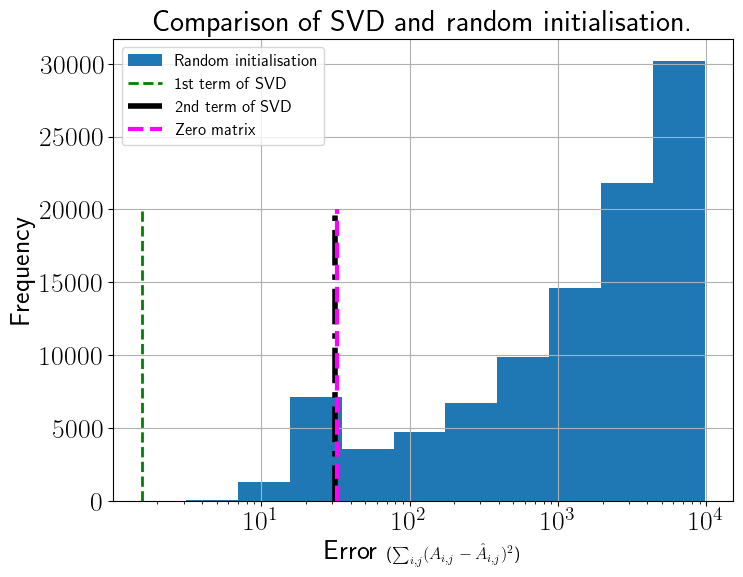

In [57]:
hist, bins, _ = plt.hist(errs, label="Random initialisation")
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.close()

hist, bins, _ = plt.hist(errs, label="Random initialisation", bins=logbins)
plt.vlines(error(approxs[0], A), ymin=0, ymax=20000, color="green", label="1st term of SVD", linestyle="dashed", linewidth=2.0)
plt.vlines(error(approxs[1], A), ymin=0, ymax=20000, color="black", label="2nd term of SVD", linestyle="dashdot", linewidth=4.0)
plt.vlines(error(np.zeros_like(A), A), ymin=0, ymax=20000, color="magenta", label="Zero matrix", linestyle="dashed", linewidth=3.0)



plt.xlabel("Error \large ($\sum_{i,j} (A_{i,j} - \hat{A}_{i,j})^2 $)")
plt.xscale('log')
plt.ylabel("Frequency")
plt.grid()
plt.title("Comparison of SVD and random initialisation.")
plt.legend(loc="upper left")
plt.savefig("svd-results.pdf")
plt.show()
plt.close()